In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

7196


In [2]:
import cv2

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

dapi_image_file = os.path.join(data_folder, 'H0M1', 'Conv_zscan_001.dax')
#dapi_im = visual_tools.DaxReader(dapi_image_file).loadAll()[3::4][0::4]
#dapi_im = im[3::4]#[::4]

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 161


In [5]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [ ]:

for _fov_id, _fov_name in enumerate(fovs):
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_fov_id}.npy')
    if os.path.exists(seg_save_file):
        continue

    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[750,488,405])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488[0::4]
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(corr_chromatic=False)
    # cellpose
    print(f"- apply microscope corrections")
    test_dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_405[0::4], microscope_params)
    test_polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    
    print(f"- run Cellpose segmentation", end=' ')
    _cellpose_start = time.time()
    test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_dapi_im])
    test_polyt_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_polyt_im])

    seg_model = models.CellposeModel(gpu=True, model_type='TN2')

    labels3d, _, _ = seg_model.eval(np.stack([test_polyt_im, test_dapi_im], axis=3), 
                                    batch_size=20, anisotropy=1000/108/2,
                                    cellprob_threshold=0, 
                                    channels=[1,2], diameter=30, min_size=100,
                                    do_3D=True,
                                    )

    print(f"in {time.time()-_cellpose_start:.3f}s.")
    
    
    # resize segmentation label back
    labels3d = np.array([cv2.resize(_ly, _cls.im_750.shape[1:], 
                                    interpolation=cv2.INTER_NEAREST_EXACT) 
                         for _ly in labels3d])

    
    print(labels3d.shape, _fov_id)
    # save this segmentation mask
    print(f"- save to file: {seg_save_file}")
    np.save(seg_save_file.split('.npy')[0], labels3d, )
    

\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_001.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_001.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_001.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.884s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.988s.
-- corrected illumination for channel 488 in 8.040s.
-- corrected illumination for channel 405 in 7.735s.
- Finished illumination correction in 24.031s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_

-- corrected illumination for channel 750 in 7.875s.
-- corrected illumination for channel 488 in 7.922s.
-- corrected illumination for channel 405 in 7.687s.
- Finished illumination correction in 23.735s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_004.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.781s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.031s.
-- corrected illumination for channel 488 in 2.031s.
- Finished illumination correction in 4.219s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.05 -9.91  4.89] in 0.828s.
-- drift 1: [-0.

-- drift 0: [-0.04 -7.78  0.99] in 0.844s.
-- drift 1: [-0.05 -7.79  1.14] in 0.828s.
-- drift 2: [-0.05 -7.81  1.01] in 0.828s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.04666667 -7.79333333  1.04666667] for channel: 750
-- finish warpping channel 750 in 22.000s.
488 False True
-- warp image with drift:[-0.04666667 -7.79333333  1.04666667] for channel: 488
-- finish warpping channel 488 in 22.094s.
-- finish warpping in 44.095s.
- apply microscope corrections
- run Cellpose segmentation in 55.891s.
(13, 2048, 2048) 7
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_7.npy
\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_008.dax \\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_008.dax
Initialize DaxProcesser for file:\\10.245.74.158\C

- Loaded images for channels:['750', '488', '405'] in 5.656s.
- Start illumination correction for channels:['750', '488', '405'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 7.750s.
-- corrected illumination for channel 488 in 7.891s.
-- corrected illumination for channel 405 in 7.938s.
- Finished illumination correction in 23.845s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220329-P_brain_M1_nonclear_adaptors\H11M12\Conv_zscan_011.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.844s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_20

## Check result

<IPython.core.display.Javascript object>


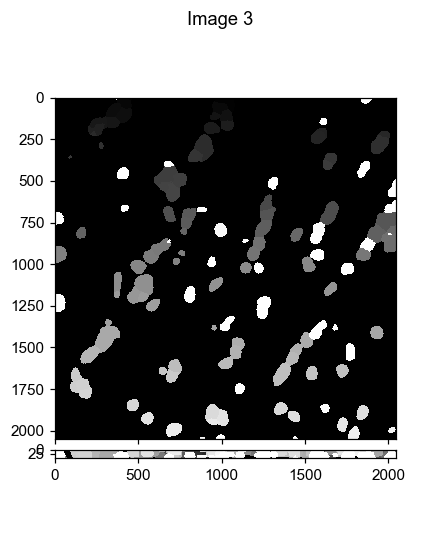

In [9]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405, _cls.im_750, labels3d])